# Imports & Installs

In [1]:
!pip install -q pytorch-msssim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.3 MB/s eta 0:00:00


In [2]:
import os
import sys
import logging

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset, random_split
from torch.cuda.amp import autocast, GradScaler
from torch.nn.functional import interpolate

from torchvision.transforms import ToTensor, Compose, RandomCrop, RandomHorizontalFlip, RandomRotation, ColorJitter, Resize, InterpolationMode
from torchvision.datasets.utils import download_url, check_integrity

from pytorch_msssim import ssim

from google.colab import drive

In [3]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)

drive.mount('/content/drive')

Using device: cuda
Mounted at /content/drive


# Loading the Data

In [4]:
def download_div2k(root, scale_factor):
    base_url = 'https://data.vision.ee.ethz.ch/cvl/DIV2K/'
    train_hr_url = f'{base_url}DIV2K_train_HR.zip'
    train_lr_url = f'{base_url}DIV2K_train_LR_bicubic_X{scale_factor}.zip'
    valid_hr_url = f'{base_url}DIV2K_valid_HR.zip'
    valid_lr_url = f'{base_url}DIV2K_valid_LR_bicubic_X{scale_factor}.zip'

    if not os.path.exists(root):
        os.makedirs(root)

    for url in [train_hr_url, train_lr_url, valid_hr_url, valid_lr_url]:
        filename = url.split('/')[-1]
        filepath = os.path.join(root, filename)

        if not check_integrity(filepath):
            logger.info(f'Downloading {filename}...')
            download_url(url, root, filename, None)
        else:
            logger.info(f'{filename} already downloaded')

        logger.info(f'Extracting {filename}...')
        extract_dir = os.path.join(root, filename[:-4])
        if not os.path.exists(extract_dir):
            os.makedirs(extract_dir)
        os.system(f'unzip -q {filepath} -d {extract_dir}')
        logger.info('Done.')

In [5]:
# Set data parameters
data_dir = '/content/div2k'
scale_factor = 2
batch_size = 32
image_size = 128

In [6]:
# Download the dataset
download_div2k(data_dir, scale_factor)

100%|██████████| 3530603713/3530603713 [04:03<00:00, 14522622.76it/s]


100%|██████████| 925390592/925390592 [01:04<00:00, 14423792.07it/s]


100%|██████████| 448993893/448993893 [00:31<00:00, 14315375.84it/s]


100%|██████████| 117763600/117763600 [00:10<00:00, 11498549.25it/s]


In [7]:
class DIV2KDataset(Dataset):
    def __init__(self, hr_dir, lr_dir, transform=None):
        self.hr_files = sorted(self._get_image_files(hr_dir))
        self.lr_files = sorted(self._get_image_files(lr_dir))
        self.transform = transform

    def _get_image_files(self, directory):
        image_files = []
        for root, dirs, files in os.walk(directory):
            for dir in dirs:
                if dir.startswith("DIV2K_train_HR") or dir.startswith("DIV2K_valid_HR") or dir.startswith("X2"):
                    subdir = os.path.join(root, dir)
                    for file in os.listdir(subdir):
                        if file.endswith(".png") or file.endswith(".jpg") or file.endswith(".jpeg"):
                            image_files.append(os.path.join(subdir, file))
        return image_files

    def __len__(self):
        return len(self.hr_files)

    def __getitem__(self, idx):
        hr_path = self.hr_files[idx]
        lr_path = self.lr_files[idx]

        try:
            hr_image = plt.imread(hr_path)
            lr_image = plt.imread(lr_path)
        except (OSError, ValueError) as e:
            logger.error(f"Error loading image files: {e}")
            raise

        if self.transform:
            hr_image, lr_image = self.transform(hr_image, lr_image)

        return hr_image, lr_image

In [8]:
def collate_fn(batch):
    hr_images = [item[0] for item in batch]
    lr_images = [item[1] for item in batch]

    hr_images_resized = [torch.nn.functional.interpolate(img.unsqueeze(0), size=(image_size, image_size), mode='bicubic', align_corners=False).squeeze(0) for img in hr_images]
    hr_images = torch.stack(hr_images_resized, dim=0)

    lr_images_resized = [torch.nn.functional.interpolate(img.unsqueeze(0), size=(image_size // scale_factor, image_size // scale_factor), mode='bicubic', align_corners=False).squeeze(0) for img in lr_images]
    lr_images = torch.stack(lr_images_resized, dim=0)

    return hr_images, lr_images

def transform_data(hr_image, lr_image):
    hr_tensor = ToTensor()(hr_image)
    lr_tensor = ToTensor()(lr_image)
    return hr_tensor, lr_tensor

In [9]:
def load_dataset(data_dir, batch_size, image_size, scale_factor):
    train_hr_dir = os.path.join(data_dir, 'DIV2K_train_HR')
    train_lr_dir = os.path.join(data_dir, f'DIV2K_train_LR_bicubic_X{scale_factor}')
    valid_hr_dir = os.path.join(data_dir, 'DIV2K_valid_HR')
    valid_lr_dir = os.path.join(data_dir, f'DIV2K_valid_LR_bicubic_X{scale_factor}')

    train_dataset = DIV2KDataset(train_hr_dir, train_lr_dir, transform=transform_data)
    valid_dataset = DIV2KDataset(valid_hr_dir, valid_lr_dir, transform=transform_data)

    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2, collate_fn=collate_fn)
    test_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2, collate_fn=collate_fn)

    return train_loader, val_loader, test_loader

In [10]:
# Load the dataset as DataLoaders
train_loader, val_loader, test_loader = load_dataset(data_dir, batch_size, image_size, scale_factor)

# Exploring the Data

In [11]:
def display_dataloader_info(train_loader, val_loader, test_loader):
    print("Dataset Information:")
    print(f"Train Set: {len(train_loader.dataset)} samples")
    print(f"Validation Set: {len(val_loader.dataset)} samples")
    print(f"Test Set: {len(test_loader.dataset)} samples")
    print(f"Batch Size: {train_loader.batch_size}")
    print(f"Number of Batches - Train: {len(train_loader)}")
    print(f"Number of Batches - Validation: {len(val_loader)}")
    print(f"Number of Batches - Test: {len(test_loader)}")

In [12]:
# Display DataLoader information
display_dataloader_info(train_loader, val_loader, test_loader)

Dataset Information:
Train Set: 640 samples
Validation Set: 160 samples
Test Set: 100 samples
Batch Size: 32
Number of Batches - Train: 20
Number of Batches - Validation: 5
Number of Batches - Test: 4


In [13]:
def display_example_images(data_loader, num_images=5):
    batch = next(iter(data_loader))
    hr_images, lr_images = batch

    num_images = min(num_images, len(hr_images))
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 20))

    for i in range(num_images):
        hr_image = hr_images[i].permute(1, 2, 0).numpy()
        lr_image = lr_images[i].permute(1, 2, 0).numpy()

        axes[i, 0].imshow(np.clip(hr_image, 0, 1))
        axes[i, 0].set_title(f"High-Resolution {i+1}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(np.clip(lr_image, 0, 1))
        axes[i, 1].set_title(f"Low-Resolution {i+1}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

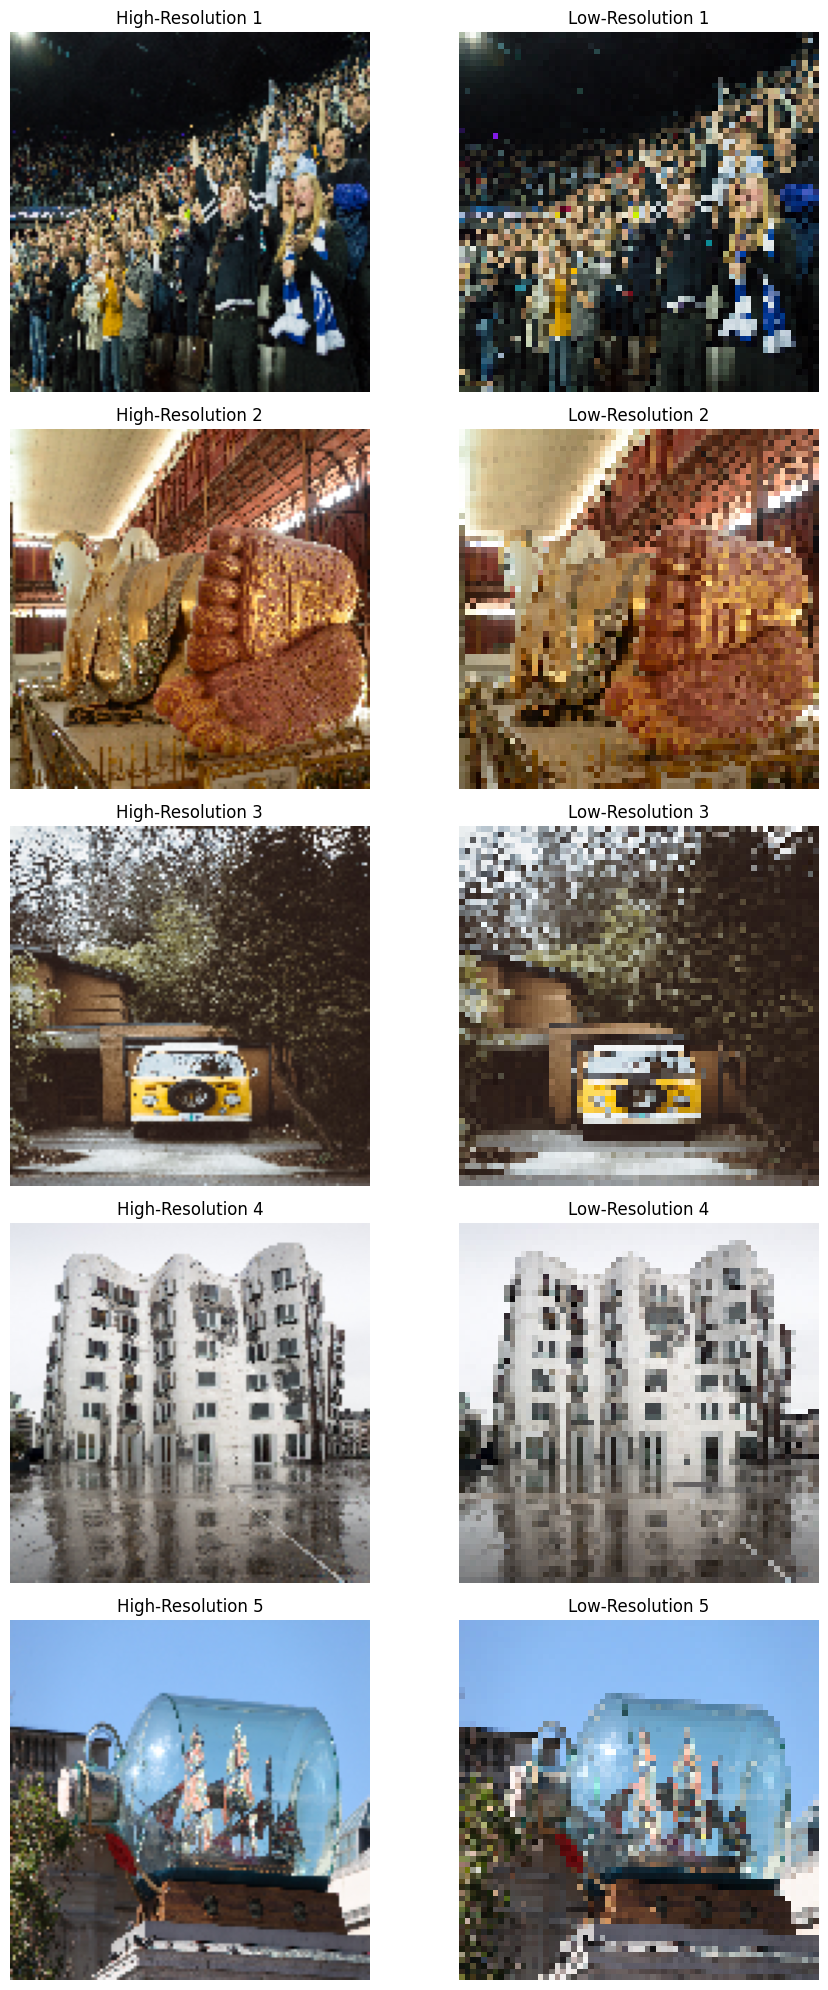

In [14]:
# Display example images
display_example_images(train_loader, num_images=5)

# Creating the Model

In [15]:
class UnrolledADMMLayer(nn.Module):
    def __init__(self, in_channels, num_filters, image_size):
        super(UnrolledADMMLayer, self).__init__()
        self.conv_y = nn.Conv2d(in_channels, num_filters, kernel_size=3, padding=1)
        self.conv1 = nn.Conv2d(num_filters * 2, num_filters, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_filters)
        self.conv2 = nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_filters)
        self.conv3 = nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_filters)
        self.relu = nn.LeakyReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.2)
        self.image_size = image_size
        self.rho = nn.Parameter(torch.tensor(0.1))

    def forward(self, y, x, z, u):
        y_conv = self.conv_y(y)
        x = self.conv1(torch.cat([x, z - u], dim=1))
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)

        residual = x
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x + residual)

        z = self.relu(x + u)

        rho_expanded = self.rho.view(1, 1, 1, 1).expand_as(x)
        u = u + rho_expanded * (x - z)

        return y_conv, x, z, u

In [16]:
class UnrolledADMMNet(nn.Module):
    def __init__(self, num_iterations, num_filters, scale_factor, image_size):
        super(UnrolledADMMNet, self).__init__()
        self.num_iterations = num_iterations
        self.scale_factor = scale_factor
        self.conv_y = nn.Conv2d(3, num_filters, kernel_size=3, padding=1)
        self.admm_layers = nn.ModuleList([
            UnrolledADMMLayer(num_filters, num_filters, image_size) for _ in range(num_iterations)
        ])
        self.final_conv = nn.Conv2d(num_filters, 3, kernel_size=3, padding=1)
        self.relu = nn.LeakyReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.2)
        self.image_size = image_size
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, y):
        y_upsampled = interpolate(y, scale_factor=self.scale_factor, mode='bicubic', align_corners=False)
        y_conv = self.conv_y(y_upsampled)
        x = torch.zeros_like(y_conv)
        z = torch.zeros_like(y_conv)
        u = torch.zeros_like(y_conv)

        for layer in self.admm_layers:
            y_conv, x, z, u = layer(y_conv, x, z, u)

        x = self.final_conv(x)
        x = self.relu(x + y_upsampled)
        return x

In [17]:
# Create the model
num_iterations = 6
num_filters = 32

unrolled_model = UnrolledADMMNet(num_iterations, num_filters, scale_factor, image_size).to(device)

# Training the Model

In [18]:
def train(model, train_loader, val_loader, num_epochs, device, lr=1e-4, lambda_reg=1e-3, patience=5, checkpoint_dir='./checkpoints'):
    criterion = nn.L1Loss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=lambda_reg)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
    scaler = GradScaler()

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model = None
    early_stop_counter = 0

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    accumulation_steps = 4

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch")

        for i, (hr_images, lr_images) in enumerate(progress_bar):
            hr_images = hr_images.to(device)
            lr_images = lr_images.to(device)

            with autocast():
                sr_images = model(lr_images)
                loss = criterion(sr_images, hr_images)

                rho_reg = 0
                for layer in model.admm_layers:
                    rho_reg += torch.norm(layer.rho)
                loss += lambda_reg * rho_reg

            scaler.scale(loss / accumulation_steps).backward()

            if (i + 1) % accumulation_steps == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                old_scaler = scaler.get_scale()
                scaler.step(optimizer)
                scaler.update()
                new_scaler = scaler.get_scale()

                if old_scaler <= new_scaler:
                    scheduler.step()

                optimizer.zero_grad()

                torch.cuda.empty_cache()

            epoch_train_loss += loss.item() * hr_images.size(0)
            progress_bar.set_postfix(loss=loss.item())

            del hr_images, lr_images, sr_images

        epoch_train_loss /= len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for hr_images, lr_images in val_loader:
                hr_images = hr_images.to(device)
                lr_images = lr_images.to(device)

                sr_images = model(lr_images)
                loss = criterion(sr_images, hr_images)

                rho_reg = 0
                for layer in model.admm_layers:
                    rho_reg += torch.norm(layer.rho)
                loss += lambda_reg * rho_reg

                epoch_val_loss += loss.item() * hr_images.size(0)

                del hr_images, lr_images, sr_images
                torch.cuda.empty_cache()

        epoch_val_loss /= len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        progress_bar.write(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model = model.state_dict()
            torch.save(best_model, os.path.join(checkpoint_dir, 'best_model.pth'))
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

        torch.cuda.empty_cache()

    model.load_state_dict(best_model)
    return model, train_losses, val_losses

In [19]:
# Training parameters
num_epochs = 5
lr = 1e-2
lambda_reg = 1e-4
patience = 3

In [20]:
# Train the unrolled model
checkpoint_dir = './checkpoints/unrolled_admm'

trained_model, train_losses, val_losses = train(unrolled_model, train_loader, val_loader, num_epochs, device, lr, lambda_reg, patience, checkpoint_dir)

Epoch 1/5:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch [1/5], Train Loss: 0.0789, Val Loss: 0.0793, LR: 0.010000


Epoch 2/5:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch [2/5], Train Loss: 0.0789, Val Loss: 0.0793, LR: 0.010000


Epoch 3/5:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch [3/5], Train Loss: 0.0789, Val Loss: 0.0793, LR: 0.010000


Epoch 4/5:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch [4/5], Train Loss: 0.0792, Val Loss: 0.0795, LR: 0.000001
Early stopping at epoch 4


# Plotting the Losses

In [21]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

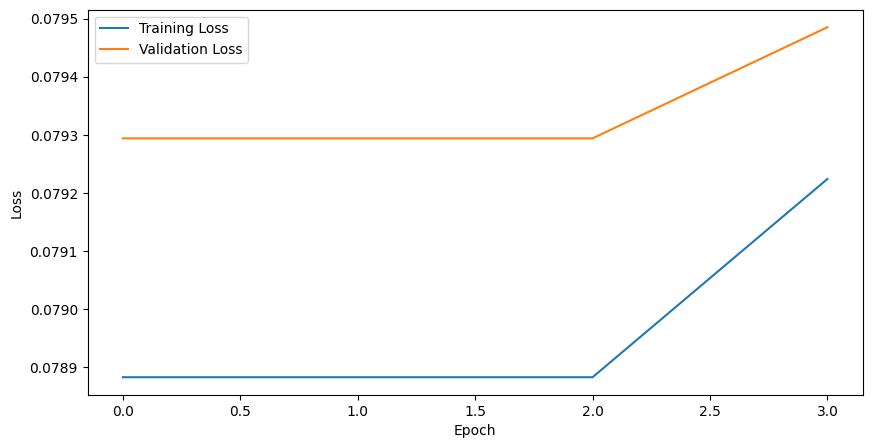

In [22]:
# Plot the losses
plot_losses(train_losses, val_losses)

# Evaluating the Model

In [23]:
def evaluate(model, test_loader, device):
    model.eval()
    test_loss = 0
    test_psnr = 0
    test_ssim = 0
    criterion = nn.L1Loss()

    with torch.no_grad():
        for hr_images, lr_images in test_loader:
            hr_images = hr_images.to(device)
            lr_images = lr_images.to(device)

            sr_images = model(lr_images)
            loss = criterion(sr_images, hr_images)

            test_loss += loss.item() * hr_images.size(0)
            test_psnr += 10 * torch.log10(1 / loss)
            test_ssim += ssim(sr_images, hr_images, data_range=1, size_average=True)

    test_loss /= len(test_loader.dataset)
    test_psnr /= len(test_loader)
    test_ssim /= len(test_loader)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test PSNR: {test_psnr:.2f} dB")
    print(f"Test SSIM: {test_ssim:.4f}")

In [24]:
# Evaluate the model
evaluate(trained_model, test_loader, device)

Test Loss: 0.0815
Test PSNR: 10.65 dB
Test SSIM: 0.5418


# Visualizing the Results

In [25]:
def visualize_results(hr_image, lr_image, model, device):
    model.eval()
    with torch.no_grad():
        hr_tensor = hr_image.unsqueeze(0).to(device)
        lr_tensor = lr_image.unsqueeze(0).to(device)
        sr_tensor = model(lr_tensor)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    hr_image = np.clip(hr_tensor[0].cpu().numpy().transpose(1, 2, 0), 0, 1)
    lr_image = np.clip(lr_tensor[0].cpu().numpy().transpose(1, 2, 0), 0, 1)
    sr_image = np.clip(sr_tensor[0].cpu().numpy().transpose(1, 2, 0), 0, 1)

    axes[0].imshow(hr_image)
    axes[0].set_title("High-Resolution")
    axes[0].axis('off')

    axes[1].imshow(lr_image)
    axes[1].set_title("Low-Resolution")
    axes[1].axis('off')

    axes[2].imshow(sr_image)
    axes[2].set_title("Super-Resolution")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

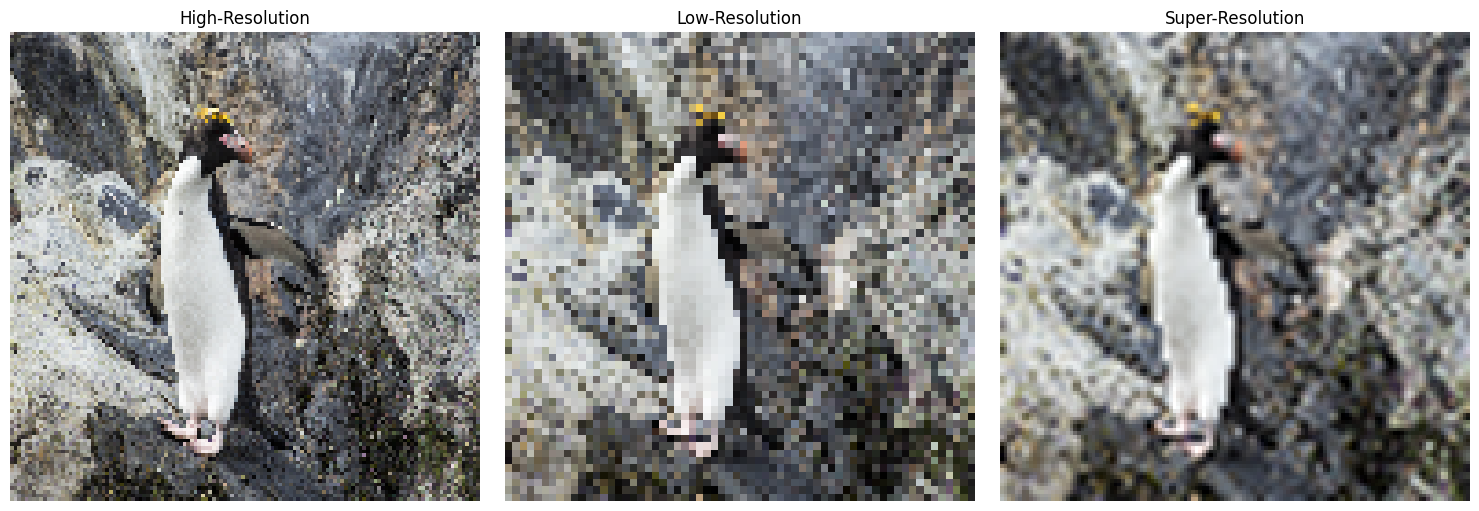

In [26]:
# Visualize the results
hr_image, lr_image = next(iter(test_loader))
visualize_results(hr_image[0], lr_image[0], trained_model, device)